# Mars Rover Project
#### `CSE 483 Computer Vision`
###### Collaborators
1. Mohammed Ahmed Abdelmegeed
2. Kareem Ahmed Abdelraouf Azab
3. Alyeldeen Khaled
4. Abdelrahman Ibrahim
5. Alia Tamer Fathi
6. Ahmed Akram

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [2]:
# %matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
from sklearn.cluster import KMeans
# imageio.plugins.ffmpeg.download()

## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

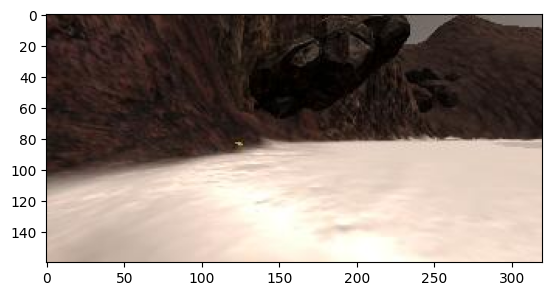

In [3]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.

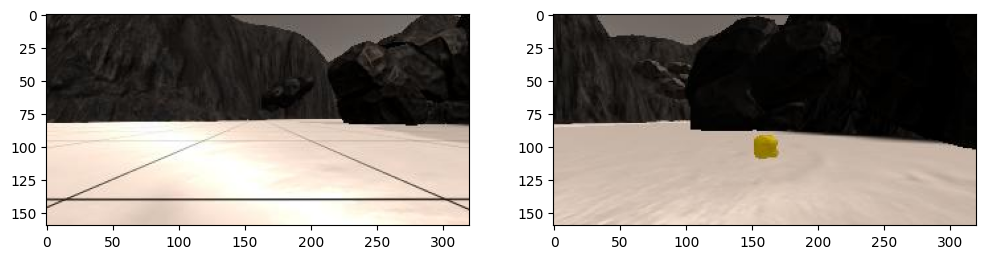

In [4]:
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

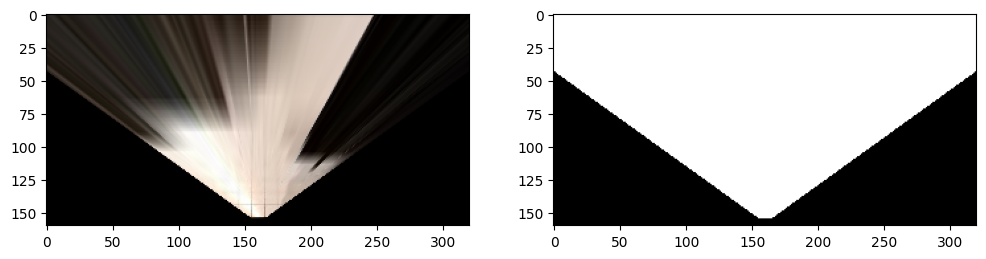

In [5]:
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
    

        # creating a circle of zeros using a variable
    circle = np.ones((150, 150), dtype="uint8")
    circle_mask=cv2.circle(circle, (75, -33), 75, 0, -1)
    circle_mask=cv2.resize(circle_mask,(img.shape[1], img.shape[0]))
    img=cv2.bitwise_and(img,img,mask=circle_mask)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    mask = cv2.warpPerspective(np.ones_like(img[:,:,0]), M, (img.shape[1], img.shape[0]))

    
    return warped, mask


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 


# circle = np.ones((150, 150), dtype="uint8")
# circle_mask=cv2.circle(circle, (75, -33), 75, 0, -1)



# cv2.imshow("Circle : ", circle)   
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped, mask, = perspect_transform(grid_img, source, destination)
fig=plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(warped)
plt.subplot(122)
plt.imshow(mask, cmap='gray')


## Color Thresholding
Define the color thresholding function from the walkthrough and apply it to the warped image

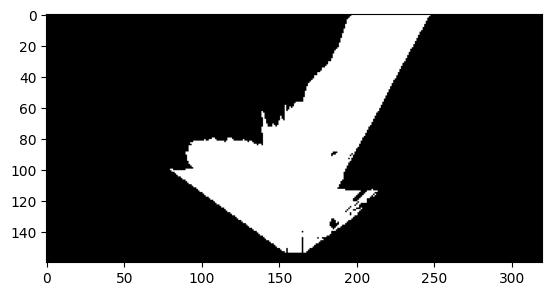

In [6]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

/tmp/ipykernel_7337/215435625.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
/tmp/ipykernel_7337/215435625.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)


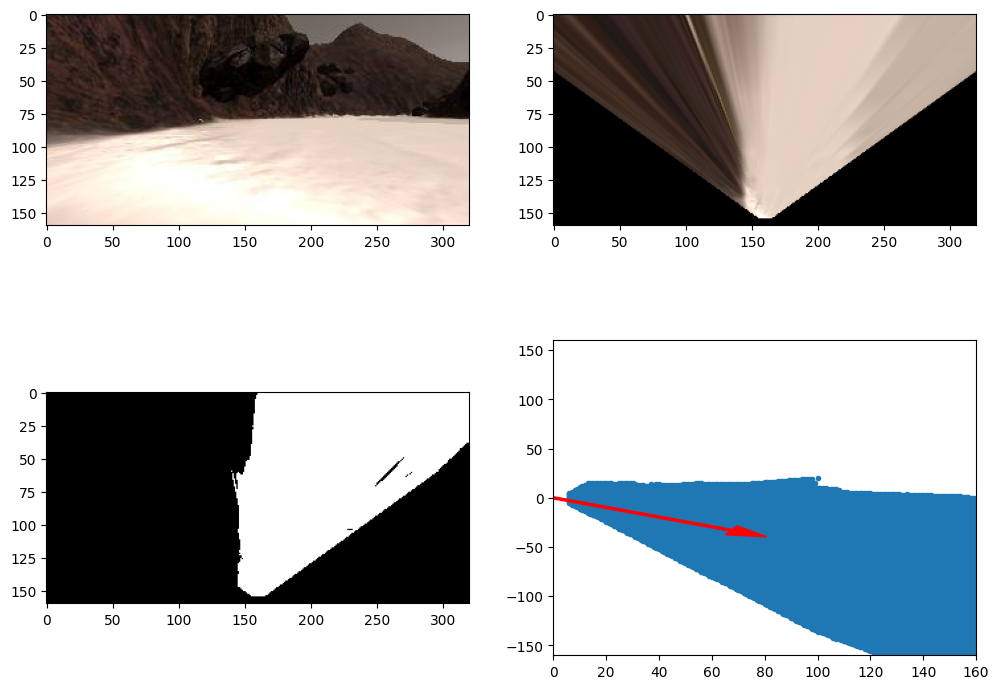

In [7]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped,mask = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 75
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)



## Read in saved data and ground truth map of the world


In [8]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


/tmp/ipykernel_7337/2123063853.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)
/tmp/ipykernel_7337/2123063853.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.worldmap = np.zeros((200, 200, 3)).astype(np.float)


## Define a function ro find rocks based on an RGB threshold

In [9]:
def find_rocks(img, levels=(130,140,30)): #Default RGB threshold values chosen
    rockpix = (( img[:,:,0]>levels[0]) \
                & (img[:,:,1] < levels[1]) \
                & (img[:,:,2] < levels[2]))
    
    color_select=np.zeros_like(img[:,:,0])
    color_select[rockpix]=1
    
    return color_select

# Using K-Means algorithm to compute RGB threshold values by clustering

In [10]:
magnified_rock=rock_img[75:125,140:175]
rock=magnified_rock
magnified_rock=magnified_rock.reshape((magnified_rock.shape[1]*magnified_rock.shape[0],3))
kmeans=KMeans(n_clusters=4) #Using 4 clusters
s=kmeans.fit(magnified_rock)
labels=kmeans.labels_
labels=list(labels)
centroid=kmeans.cluster_centers_
percent=[]
for i in range(len(centroid)):
  j=labels.count(i)
  j=j/(len(labels))
  percent.append(j)


# Computing Threshold Values
red_thresh=(centroid[2][0]-15)
green_thresh=(centroid[2][1]+centroid[3][1])/2
blue_thresh=(centroid[2][2]+centroid[3][2])/2

#Applying the threshold on the test rock image using computed RGB threshold values
rock_map = find_rocks(rock_img,levels=(red_thresh, green_thresh, blue_thresh))

/home/azab/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Clustering steps and output
1. Cropping the image to try and get the rock only and some of the background `magnified_rock`
2. Apply the K-Means algorith on the `magnified_rock` image and output the piechart with colors and percentages.
3. Get the RGB values of the yellow segments in the pie chart.
4. Apply the threshold using the computed RGB values and output the final black and white image with the rock only.

### Outputs in order of appearance:
1. The original image
2. The cropped `(magnified_rock)` image
3. The pie chart with specified number of clusters (4 clusters)
4. The original image with the threshold applied

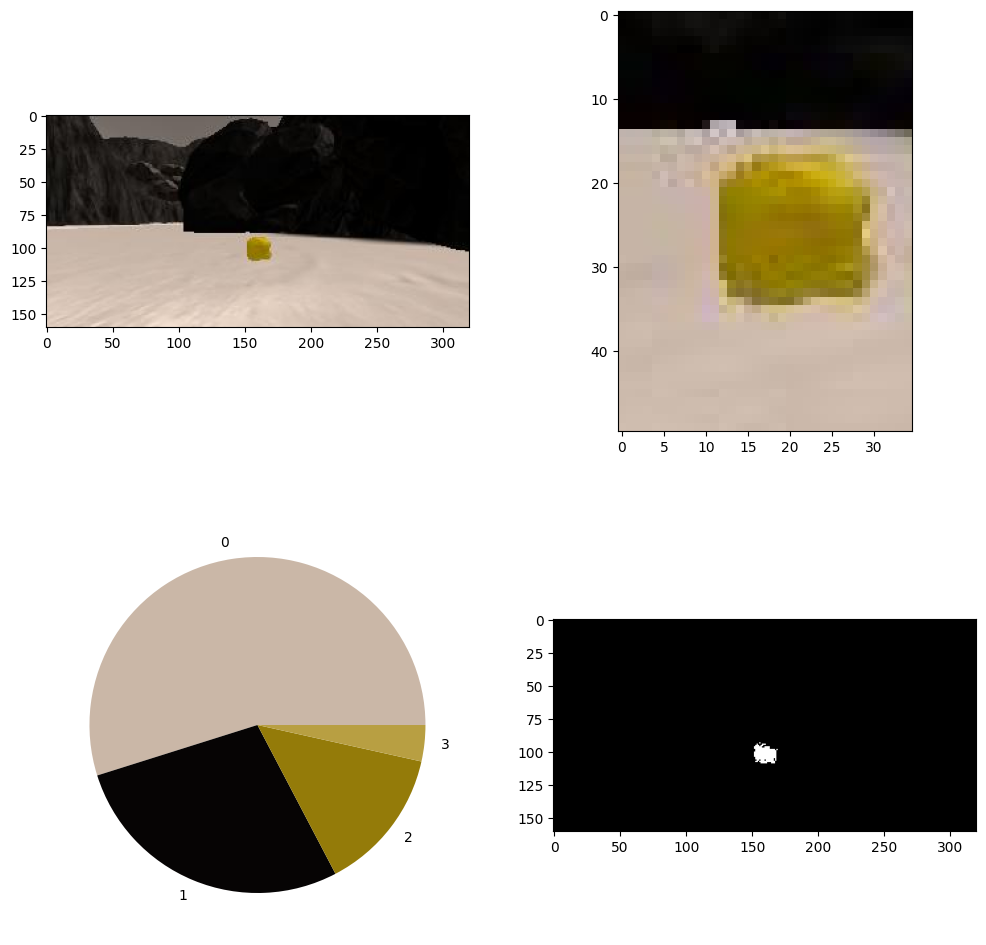

In [11]:
fig = plt.figure(figsize=(12,12))
plt.subplot(222)
plt.imshow(rock)
plt.subplot(224)
plt.imshow(rock_map,cmap='gray')
plt.subplot(221)
plt.imshow(rock_img)
plt.subplot(223)
plt.pie(percent,colors=np.array(centroid/255),labels=np.arange(len(centroid)))
plt.show()

# Color Quantization
Another approach to compute the RGB Threshold values by using K-Means Clustering

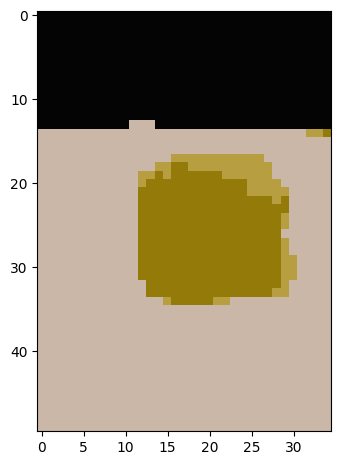

In [12]:
def quantimage(image,k):
    i = np.float32(image).reshape(-1,3)
    condition = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,20,1.0)
    ret,label,center = cv2.kmeans(i, k , None, condition,10,cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    final_img = center[label.flatten()]
    final_img = final_img.reshape(image.shape)
    return final_img

updated_rock_img=quantimage(rock, 4)
fig = plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(updated_rock_img)

## Write a function to process stored images

This function works on processing stored images, simulating the Rover's vision. While running the simulator and `drive_rover.py`, the function rover_perception is going to be called, which takes the whole Rover object as an argument, and processes the Rover's vision with the same logic applied in the `process_image` function implemented in the notebook.

In [122]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):   
    warped,mask = perspect_transform(img, source, destination)
    threshed=color_thresh(warped) # Apply threshold to warped image
    obs_map=np.absolute(np.float32(threshed)-1) * mask
    xpix, ypix = rover_coords(threshed) #Get rover coordinates
    #Convert rover coordinates to world coordinates
    world_size = data.worldmap.shape[0] #3ard el sora
    print(world_size) # will print 200 because the world is 200x200
    scale = 2*dst_size
    xpos = data.xpos[data.count]
    print(xpos)
    ypos = data.ypos[data.count]
    yaw = data.yaw[data.count]
    
    x_world, y_world = pix_to_world(xpix, ypix, xpos, ypos,
                                   yaw, world_size, scale)
    print(x_world , y_world)
    obsxpix, obsypix = rover_coords(obs_map)
    obs_x_world, obs_y_world = pix_to_world(obsxpix, obsypix, xpos, ypos,
                                   yaw, world_size, scale)
    data.worldmap[y_world, x_world, 2] = 255 # Coloring the blue channel for the navigable road
    data.worldmap[obs_y_world, obs_x_world, 0] = 255 # Coloring the red channel for the obstacles
    nav_pix=data.worldmap[:,:,2] > 0 # Getting all pixels in the blue channel which have a value set "greater than 0"
    data.worldmap[nav_pix, 0] = 0 #setting pixels which have a value greater than 0 in the blue channel, to 0 in the red channel
    #to avoid any intersections between the navigable road and the obstacles
    
    
    #################   Finding Rocks
    rock_map= find_rocks(warped, levels=(130,140,50))
    if rock_map.any():
        rock_x, rock_y = rover_coords(rock_map)
        rock_x_world, rock_y_world = pix_to_world(rock_x, rock_y, xpos, ypos,
                                   yaw, world_size, scale)
        data.worldmap[rock_y_world, rock_x_world, :] = 255
    
        
        
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img
    
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [123]:
# Import everything needed to edit/save/watch video clips
from signal import signal, SIGPIPE,SIG_DFL
import sys
import errno
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip



try:
    # Define pathname to save the output video
    output = '../output/test_mapping3.mp4'
    data = Databucket()
    clip = ImageSequenceClip(data.images, fps=60)
    new_clip = clip.fl_image(process_image)
    %time new_clip.write_videofile(output, audio=False)
except IOError as e:
    if e.errno == errno.EPIPE:
        signal(SIGPIPE, SIG_DFL)


ModuleNotFoundError: No module named 'moviepy'

### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [124]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

NameError: name 'output' is not defined

### Below is an alternative way to create a video in case the above cell did not work.

In [125]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))

NameError: name 'output' is not defined